# ARIMA Modeling

> Authors: Matt Brems, Joseph Nelson, Justin Pounders, Leo (SG)

In [1]:
#  !pip install -U pmdarima

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv('../data/global_land_temps.csv')

print(df.shape)
df.head()

(3159, 2)


,date,avg_temp
0,1752-10-01,7.839
1,1752-11-01,7.335
2,1752-12-01,5.086
3,1753-01-01,2.039
4,1753-02-01,0.715


### Global Temperature Data
> We have [average temperature data](https://data.world/data-society/global-climate-change-data) for the globe from 1750 to 2015.
- `date`: the month the data was measured.
- `avg_temp`: the average global temperature (in degreed Celsius).

In [4]:
# Convert 'date' column to datetime
df['date'] = pd.to_datetime(df['date'])

# Set index to be the date column 
df = df.set_index('date')

# Confirm.
df.head()

,avg_temp
date,
1752-10-01,7.839
1752-11-01,7.335
1752-12-01,5.086
1753-01-01,2.039
1753-02-01,0.715


Let's plot this raw data.

In [5]:
# Plot the temperature over time
def plot_series(df, col, title='Title', xlab=None, ylab=None, steps=1):
    
    # Set figure size to be (18, 9).
    plt.figure(figsize=(18,9))
               
    # Generate a line plot of the column name.
    # You only have to specify Y, since our
    # index will be a datetime index.
    plt.plot(df[col])
        
    # Generate title and labels.
    plt.title(title, fontsize=26)
    plt.xlabel(xlab, fontsize=20)
    plt.ylabel(ylab, fontsize=20)
    
    # Enlarge tick marks.
    plt.yticks(fontsize=18)
    plt.xticks(df.index[0::steps], fontsize=18);

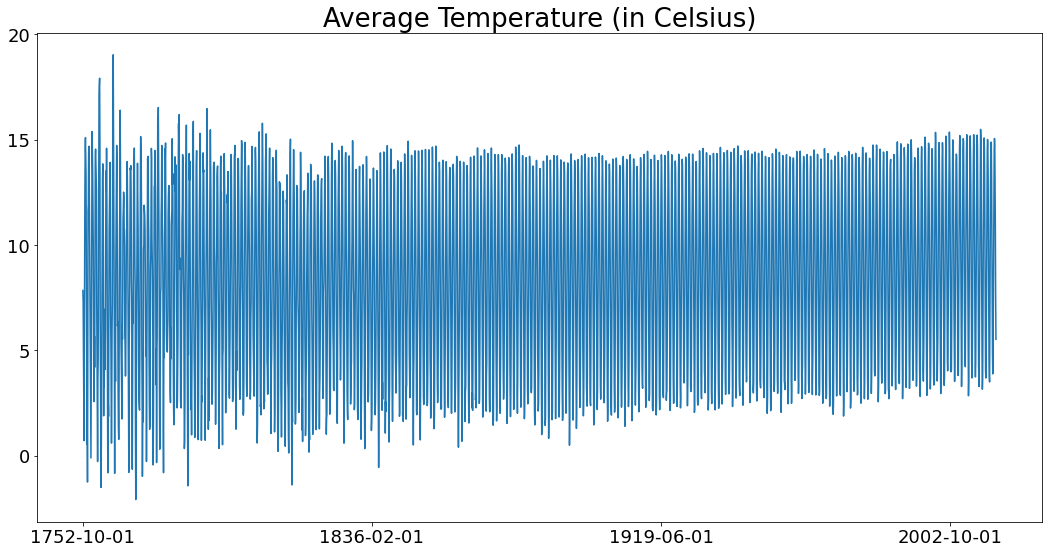

In [6]:
# Generate a time plot of our data.
plot_series(df, 'avg_temp', title = "Average Temperature (in Celsius)", steps=1000)

<details><summary>What Pandas function may be helpful here?</summary>

- We'll use `.resample()`.
</details>

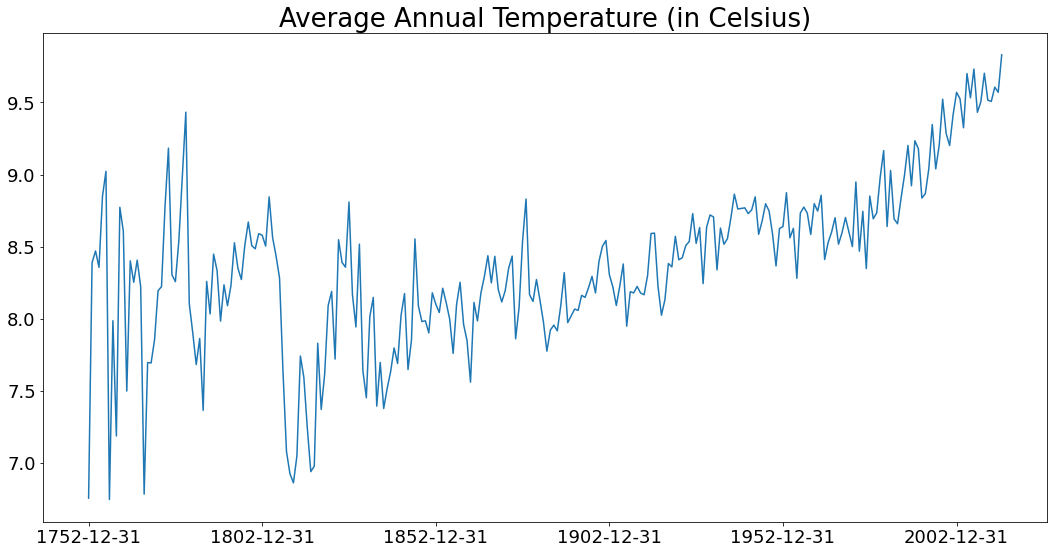

In [7]:
# Generate a time plot of our data.
plot_series(df.resample('A').mean(), col='avg_temp', title='Average Annual Temperature (in Celsius)', steps=50)

- The initial data has very large fluctuations
- Given that it was in the 18th and 19th century its reasonable to assume the measurement equipment were not very accurate back then
- So let's only keep only data from 1950 onwards

In [8]:
# Overwrite df.
df = df['1950':]
df.head()

,avg_temp
date,
1950-01-01,2.008
1950-02-01,2.721
1950-03-01,5.247
1950-04-01,8.123
1950-05-01,11.297


<details><summary>Check: How would you describe this data?</summary>
    
- **Trend**: The mean is increasing over time and it looks like it speeds up toward the end of the 1960s.
- **Seasonality**: There are fluctuations, but it's tough to see if there are fluctuations on a fixed and known frequency.
- **Autocorrelation**: The data are correlated with one another.
</details>

## ARIMA Model

<details><summary>Check: Recall that $AR$ incorporates information from long-term trends and $MA$ incorporates information from sudden shocks. What are some examples where we might see both long-term trends and sudden fluctuations in our time series data? </summary>

- Stock price data. Stocks increase and decrease over time, but news or other stock changes may have sudden effects on prices. (Similar logic applies to gas or oil prices.)
- Public transportation ridership. While public transportation may see slow changes over time, marketing campaigns, changes in price, or accidents may have a sudden, unforeseen shock on ridership.
- Temperature data over time!
</details>

### Fitting an ARIMA Model
- In order to fit an ARIMA model, we need to specify three parameters: $p$, $d$, and $q$.
- In the past we'd have to do this manually
    - First we'd fix $d$ as the number of times we need to difference the data till it becomes stationary. We'd use the Augmented Dickey-Fuller Test which gives us a p-value to determine how many orders of differencing are needed to make the process stationary.
    - Next, we'd run a grid search for different values of $p$ and $q$ to find the best values that minimises the prediction error
- However, nowadays, we can use Auto ARIMA! This will take care of everything for us under the hood!

An $ARIMA(p, d, q)$ model is specified by:
- how many differences $d$ we need to calculate in order to achieve stationarity.
- how many lags $p$ we regress $Y_t^{(d)}$ on.
- how many errors $q$ we regress $Y_t^{(d)}$ on.

Depending on our values of $p$, $d$, and $q$, we might refer to these models by slightly different names.

- If $d=0$ and $q=0$, an AR(p) model is specified by how many lags $p$ we regress $Y_t$ on.
- If $d=0$ and $p=0$, an MA(q) model is specified by how many errors $q$ we regress $Y_t$ on.
- If $d=0$, an ARMA(p, q) model is specified by how many lags $p$ and how many errors $q$ we regress $Y_t$ on.

| p | d | q |          Model         |
|:-:|:-:|:-:|:----------------------:|
| 1 | 0 | 0 |  ARIMA(1,0,0) = AR(1)  |
| 0 | 0 | 1 |  ARIMA(0,0,1) = MA(1)  |
| 1 | 0 | 1 | ARIMA(1,0,1) = ARMA(1,1) |
| 1 | 1 | 1 |      ARIMA(1,1,1)      |
| 1 | 1 | 0 |      ARIMA(1,1,0)      |
| 0 | 1 | 1 |      ARIMA(0,1,1)      |


To recap: stationarity means that there **aren't systematic changes in our time series over time**.
- Our mean stays the same. (There is no trend.)
- The autocorrelation between $Y_t$ and $Y_{t-k}$ depends only on the size of our lag $k$. (There is no seasonality.)
- A [white noise process](https://stats.stackexchange.com/questions/7070/what-is-a-white-noise-process) is a common example of a stationary time series.

<details><summary>Is our data stationary?</summary>
    
- No! The mean is not constant over time. It looks like the mean increases over time.
</details>

Again, why do we difference? 
- Differencing allows us to get a stationary time series out of a non-stationary time series.
- This means that we'll be able to fit an ARIMA model to the **differenced** data!

How do we know if we let $d=1$ or $d=2$?

#### Checking for Stationarity: the Augmented Dickey-Fuller Test

The [augmented Dickey-Fuller test](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test) is a hypothesis test that tests for stationarity. We assume that our data are not stationary. With enough evidence, we may accept that our data are stationary.

Specifically, the test is as follows:

$$
\begin{eqnarray}
&H_0:& \text{not stationary} \\
&H_A:& \text{stationary}
\end{eqnarray}
$$

<details><summary>Would a small $p$-value or a large $p$-value give us evidence that our time series is stationary?</summary>

- A small $p$-value would give us evidence to reject the null hypothesis, meaning we accept that our time series is stationary.
</details>

- Rather than modeling $Y_t$ directly, we'll model $Y'_t = Y_t - Y_{t-1}$.
- If we generate plots moving forward, then we should generate plots of the **differenced** time series, not the original time series!

# Auto Arima
- In the past checking for the optimum values of p, m, and d had to be found by manual experimentation and grid searching
- However, with the advent of the `pmdarima` library, we can easily do it automatically!

In [9]:
import pmdarima as pm
from pmdarima.arima import ADFTest

In [10]:
# Augmented Dickey-Fuller test 
adf_test = ADFTest(alpha = 0.05) 
adf_test.should_diff(df['avg_temp'])

(0.01, False)

- We do not need to diff the monthly time series. It is already stationary

In [11]:
# Create train-test split.
# Shuffle=False is important here as we want our Train data to be earlier in time and Test data to be later in time
y_train, y_test = train_test_split(df['avg_temp'], test_size=.1, shuffle=False)

In [12]:
# BEWARE! This will take a sometime to run!
# Fit Auto ARIMA
arima_model = pm.AutoARIMA(start_p=0, max_p=10, 
                           d=None,    # find optimum value of d automatically
                           start_q=0, max_q=10,
                           # start_P=0, max_P=10,
                           # D=None,
                           # start_Q=0, max_Q=10,
                           # m=12, # For monthly data since the pattern repeats every 12 months
                           # seasonal=True,
                           trace=True, # Print values for each fit in the grid search
                           random=True,
                           random_state=20,
                           n_fits=50
                          )

arima_model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=4051.250, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=3080.157, Time=0.25 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=3247.375, Time=0.34 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5273.607, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1241.431, Time=0.51 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.69 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=945.097, Time=1.41 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2519.522, Time=0.39 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=852.795, Time=0.93 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=848.315, Time=2.01 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=1.05 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=845.695, Time=1.83 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=1.81 sec
 ARIMA(6,0,1)(0,0,0)[0] intercept   : AIC=833.910, Time=2.11 sec
 ARIMA(6,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=2

AutoARIMA(max_p=10, max_q=10, n_fits=50, random=True, random_state=20,
          start_p=0, start_q=0, trace=True)

In [13]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  712
Model:              SARIMAX(10, 0, 1)   Log Likelihood                -265.645
Date:                Thu, 10 Feb 2022   AIC                            555.289
Time:                        20:15:22   BIC                            610.106
Sample:                             0   HQIC                           576.462
                                - 712                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0336      0.072     14.394      0.000       0.893       1.174
ar.L2         -0.0912      0.071     -1.288      0.198      -0.230       0.048
ar.L3         -0.2151      0.057     -3.753      0.000      -0.327      -0.103
ar.L4          0.0363      0.057      0.637      0.524      -0.075       0.148
ar.L5         -0.0646      0.058     -1.120      0.263      -0.178       0.048
ar.L6          0.0582      0.059      0.982      0.326      -0.058       0.174
ar.L7         -0.0425      0.058     -0.738      0.461      -0.156       0.070
ar.L8          0.0305      0.058      0.527      0.598      -0.083       0.144
ar.L9         -0.0429      0.059     -0.733      0.463      -0.158       0.072
ar.L10         0.2976      0.046      6.520      0.000       0.208       0.387
ma.L1         -0.4707      0.072     -6.493      0.000      -0.613      -0.329
sigma2         0.1198      0.006     19.800      0.000       0.108       0.132
===================================================================================
Ljung-Box (L1) (Q):                   0.53   Jarque-Bera (JB):                 7.67
Prob(Q):                              0.47   Prob(JB):                         0.02
Heteroskedasticity (H):               1.02   Skew:                            -0.20
Prob(H) (two-sided):                  0.89   Kurtosis:                         3.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

> Finding coefficients for an MA model is difficult, because the model requires us to regress on errors, but we don't actually observe these errors. The algorithm for fitting this is complicated and is well beyond the scope of this lesson. [Check more out here](https://www.it.uu.se/research/publications/reports/2006-022/2006-022-nc.pdf).

The best model found by `pmdarima` library is an $ARIMA(10,0,1)$ model.

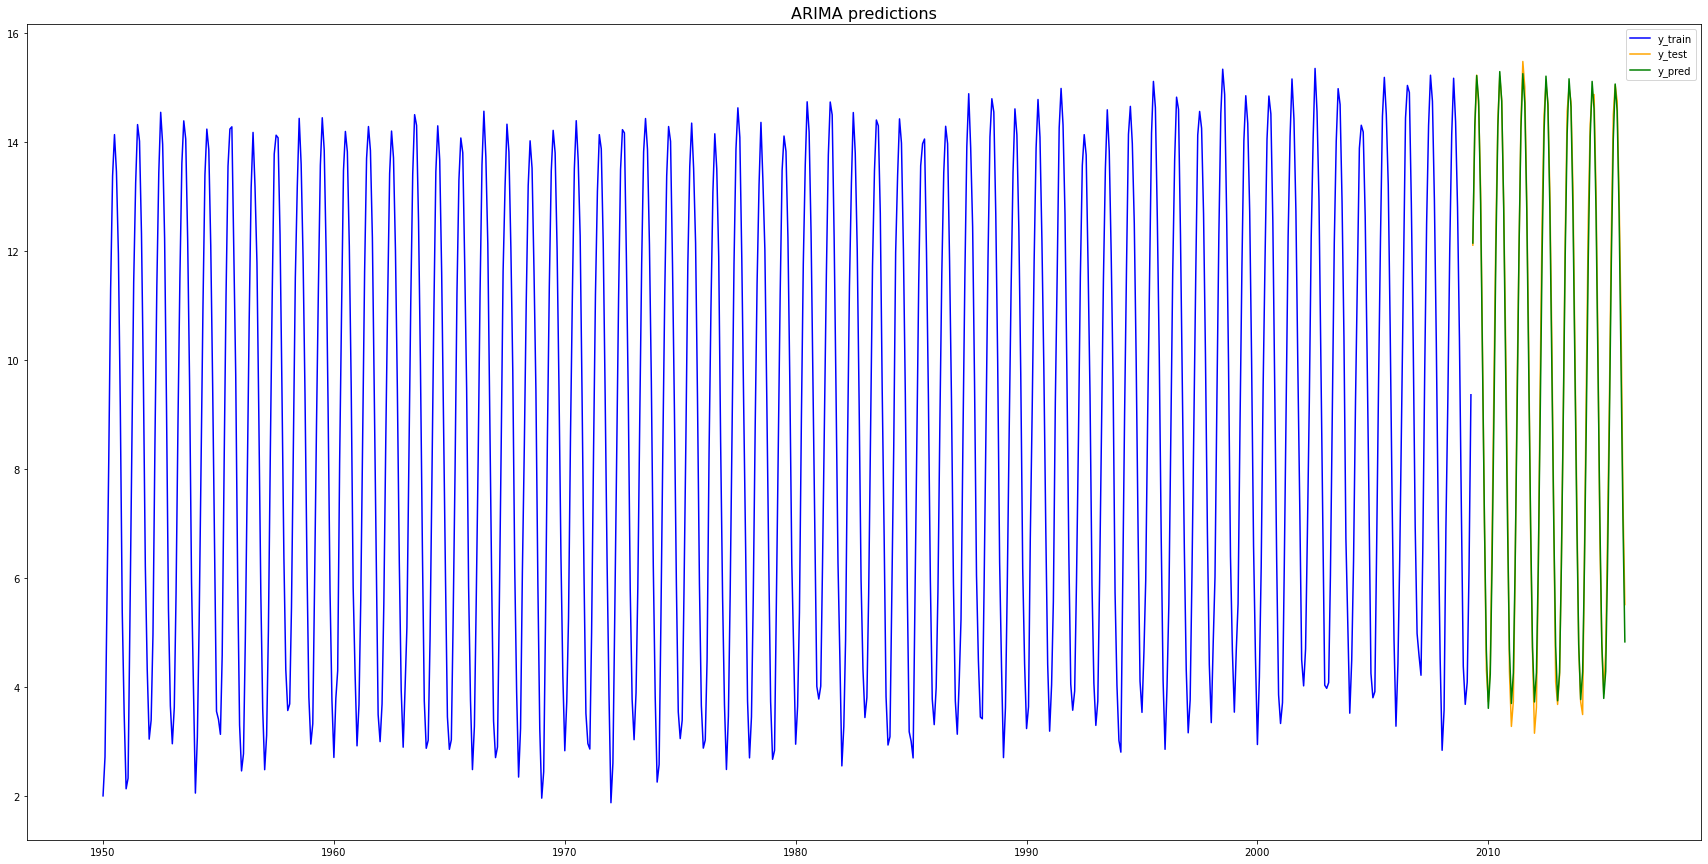

In [14]:
# Generate len(y_test) number of predictions
y_pred = arima_model.predict(n_periods = len(y_test))

# Plot data.
plt.figure(figsize=(30,15))

# Plot training data.
plt.plot(y_train, color='blue', label='y_train')

# Plot testing data.
plt.plot(y_test, color='orange', label='y_test')

# Plot predicted test values.
plt.plot(y_test.index, y_pred, color='green', label='y_pred')

plt.title(label = 'ARIMA predictions', fontsize=16)
plt.legend();

## Takeaways
- ARIMA models are among the most common approaches to time series modeling. (Despite all the advances in Neural Networks, because Neural Networks require a loooot of data!)
- Highly flexible; it can model time series with varying characteristics.
    - It takes information from both long-term trends and sudden shocks!
- Can easily be extended into more advanced models.
    - Seasonal ARIMA.
    - ARIMA with eXogenous Predictors. (Independent X variables.)
    - Vector ARIMA models. (Multiple Y variables simultaneously.)
- Tends to perform well with moderate amounts of data, but may be outperformed by deep learning methods (RNN) with lots of data. (Side note: It can be hard to get lots of time series data!)
- ARIMA models are best suited for short-term forecasts, but very quickly will start predicting the mean. Some of the extensions to ARIMA models can handle this better.

**Forecasting time series is exceptionally difficult to do well!** We're using the past to predict the future, and there aren't guarantees that the future is necessarily going to be reflective of the past. There's more uncertainty in time series than we'd see in "traditional" model-building. We saw this during the COVID-19 pandemic when many time series models broke because many historical trends stopped (travel, product purchases, commuting, etc)

### Interview Questions

<details><summary>What is temporal machine learning?</summary>

- temporal is just another word for time series
</details>

<details><summary>What are examples of time series data?</summary>

_(Answers will vary.)_
- Any data that is gathered over time is considered time series data.
- Examples include an individual's maximum heart rate per minute, average temperature per hour, number of units sold per day, amount of rainfall per month, and GDP per quarter.
</details>

<details><summary>What are some disadvantages to time series analysis methods?</summary>

_(Answers will vary.)_
- Forecasting into the future is difficult! There are more sources of uncertainty than in traditional, non-temporal machine learning.
- The amount of data gathered over time is often smaller than the amount of data in non-temporal machine learning.
- Forecasts may only be meaningful/informative for a few time periods.
- [Significant changes](gov/pmc/articles/PMC5464762/) may cause certain periods of data to be irrelevant/less relevant to solving problem. (e.g. data prior to Great Recession may not be impactful when forecasting economic data after 2009, data prior to COVID may not be meaningful when predicting consumer behavior after May 2020.)
</details>